In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
sys.path.append('/global/homes/m/mmaus/Python/velocileptors')
sys.path.append('emulator/fullshape_omb/')
from classy import Class
from make_pkclass import make_pkclass_dists
from linear_theory import f_of_a
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from velocileptors.Utils.loginterp import loginterp
from scipy.interpolate import interp1d

In [3]:
z = 0.8
fid_class, fid_dists = make_pkclass_dists(z=z)

In [63]:
omega_b,omega_cdm, h, sigma8 = [0.02237, 0.1200,0.68, 0.73]
Hzfid, chizfid = fid_dists
speed_of_light = 2.99792458e5

# omega_b = 0.02242

As =  2.0830e-9
ns = 0.9649

nnu = 1
nur = 2.0328
# mnu = 0.06
omega_nu = 0.0006442 #0.0106 * mnu
# mnu = omega_nu / 0.0106

# omega_c = (OmegaM - omega_b/h**2 - omega_nu/h**2) * h**2
OmegaM = (omega_cdm + omega_b + omega_nu) / h**2

pkparams = {
    'output': 'mPk',
    'P_k_max_h/Mpc': 20.,
    'z_pk': '0.0,10',
    'A_s': As,
    'n_s': ns,
    'h': h,
    'N_ur': nur,
    'N_ncdm': nnu,
    'omega_ncdm': omega_nu,
    # 'm_ncdm': mnu,
    'tau_reio': 0.0568,
    'omega_b': omega_b,
    'omega_cdm': omega_cdm}

pkclass = Class()
pkclass.set(pkparams)
pkclass.compute()

# Caluclate AP parameters
Hz = pkclass.Hubble(z) * speed_of_light / h # this H(z) in units km/s/(Mpc/h) = 100 * E(z)
chiz = pkclass.angular_distance(z) * (1.+z) * h # this is the comoving radius in units of Mpc/h 
apar, aperp = Hzfid / Hz, chiz / chizfid

# if ap_off:
#     apar, aperp = 1.0, 1.0

# Calculate growth rate
fnu = pkclass.Omega_nu / pkclass.Omega_m()
f   = f_of_a(1/(1.+z), OmegaM=OmegaM) * (1 - 0.6 * fnu)

# Calculate and renormalize power spectrum
ki = np.logspace(-3.0,1.0,200)
pi = np.array( [pkclass.pk_cb(k*h, z ) * h**3 for k in ki] )
pi = (sigma8/pkclass.sigma8())**2 * pi

kvec = np.concatenate( ([0.0005,],\
                        np.logspace(np.log10(0.0015),np.log10(0.025),10, endpoint=True),\
                        np.arange(0.03,0.51,0.01)) )

# Now do the RSD
ex_min = -4
ex_max = 3
N = 2000

modPT = LPT_RSD(ki, pi, kIR=0.2,\
            cutoff=10, extrap_min = ex_min, extrap_max = ex_max, N = 2000, threads=1, jn=5)
modPT.make_pltable(f, kv=kvec, apar=apar, aperp=aperp, ngauss=3)

p0table,p2table,p4table = modPT.p0ktable, modPT.p2ktable, modPT.p4ktable

In [64]:
np.shape(p0table),len(kvec)

((59, 19), 59)

In [71]:
rmin, rmax, dr = 1., 200., 0.5
rout = np.arange(rmin,rmax,dr)
kint = modPT.kint
p0int_table = np.zeros((2000,19))
p2int_table = np.zeros((2000,19))
p4int_table = np.zeros((2000,19))

xi0_table = np.zeros((len(rout),19))
xi2_table = np.zeros((len(rout),19))
xi4_table = np.zeros((len(rout),19))
for i in range(19):
    damping = np.exp(-(kint/10)**2)
    p0int = loginterp(kvec, p0table[:,i])(kint) * damping
    p2int = loginterp(kvec, p2table[:,i])(kint) * damping
    p4int = loginterp(kvec, p4table[:,i])(kint) * damping
    
    ss0, xi0t = modPT.sphr.sph(0,p0int)
    ss2, xi2t = modPT.sphr.sph(2,p2int); xi2t *= -1
    ss4, xi4t = modPT.sphr.sph(4,p4int)
    
    p0int_table[:,i] = p0int
    p2int_table[:,i] = p2int
    p4int_table[:,i] = p4int
    
    xi0_table[:,i] = interp1d(ss0,xi0t,kind='cubic')(rout) 
    xi2_table[:,i] = interp1d(ss0,xi2t,kind='cubic')(rout)
    xi4_table[:,i] = interp1d(ss0,xi4t,kind='cubic')(rout)
    

(-10.0, 10.0)

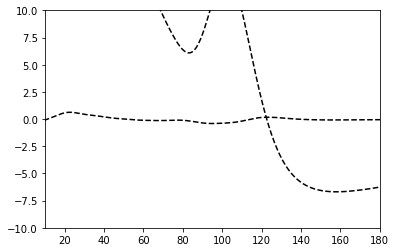

In [81]:
# np.shape(xi0t)
# plt.plot(ss0,ss0**2*xi0t,lw=4)
# plt.plot(ss0,ss0**2*xi2t,lw=4)
# plt.plot(ss0,ss0**2*xi4t,lw=4)

plt.plot(rout,rout**2*xi0_table[:,1],'k--')
plt.plot(rout,rout**2*xi2_table[:,1],'k--')
plt.plot(rout,rout**2*xi4_table[:,1],'k--')

plt.xlim(10,180)
plt.ylim(-10,10)

(0.0001, 1.0)

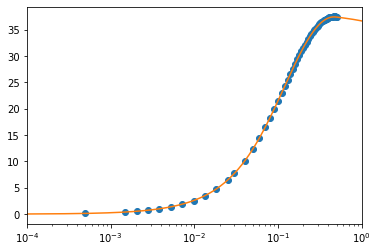

In [39]:
j=5
np.shape(p0int)
plt.semilogx(kvec,kvec*p0table[:,j],'o')
plt.semilogx(kint,kint*p0int_table[:,j])
plt.xlim(10**ex_min,1.0)
# plt.ylim(-0.01,0.01)